# Testing the model on Restricted columns (Only sleep realted column)

Introduction - Initiallly we will go through same steps like importing of libraries, data to similar data split as we seen in original model development code in ModelSleepAnalysis.ipynb code file.

In [1]:
# Importing the libraries -
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the data from Google drive.
data = pd.read_csv('/content/drive/MyDrive/Project/sleep data final.csv')

In [3]:
# Drop the 'Person ID' column
data = data.drop('Person ID', axis=1)

# Split 'Blood Pressure' into 'Systolic BP' and 'Diastolic BP'
data[['Systolic BP', 'Diastolic BP']] = data['Blood Pressure'].str.split('/', expand=True).astype(float)
data = data.drop('Blood Pressure', axis=1)

# Convert the 'Injury Risk' column to numerical labels
injury_risk_mapping = {'Fit': 0, 'Non-Fit': 1, 'Highly Non-Fit': 2}
data['Injury Risk'] = data['Injury Risk'].map(injury_risk_mapping)

# Apply one-hot encoding to categorical columns
categorical_columns = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']
data = pd.get_dummies(data, columns=categorical_columns)

# Verify the transformations
print(data.head())
print(data.info())

# At this point, you can also check the balance of the target classes
print(data['Injury Risk'].value_counts())

   Age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
0   27             6.1                 6                       42   
1   28             6.2                 6                       60   
2   28             6.2                 6                       60   
3   28             5.9                 4                       30   
4   28             5.9                 4                       30   

   Stress Level  Heart Rate  Daily Steps  Systolic BP  Injury Risk  \
0             6          77         4200        126.0            1   
1             8          75        10000        125.0            0   
2             8          75        10000        125.0            0   
3             8          85         3000        140.0            2   
4             8          85         3000        140.0            2   

   Diastolic BP  ...  Occupation_Scientist  Occupation_Software Engineer  \
0          83.0  ...                     0                             1   
1          8

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split the data into features and target
X = data.drop('Injury Risk', axis=1)
y = data['Injury Risk']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check the shape of the scaled features
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(299, 29)
(75, 29)


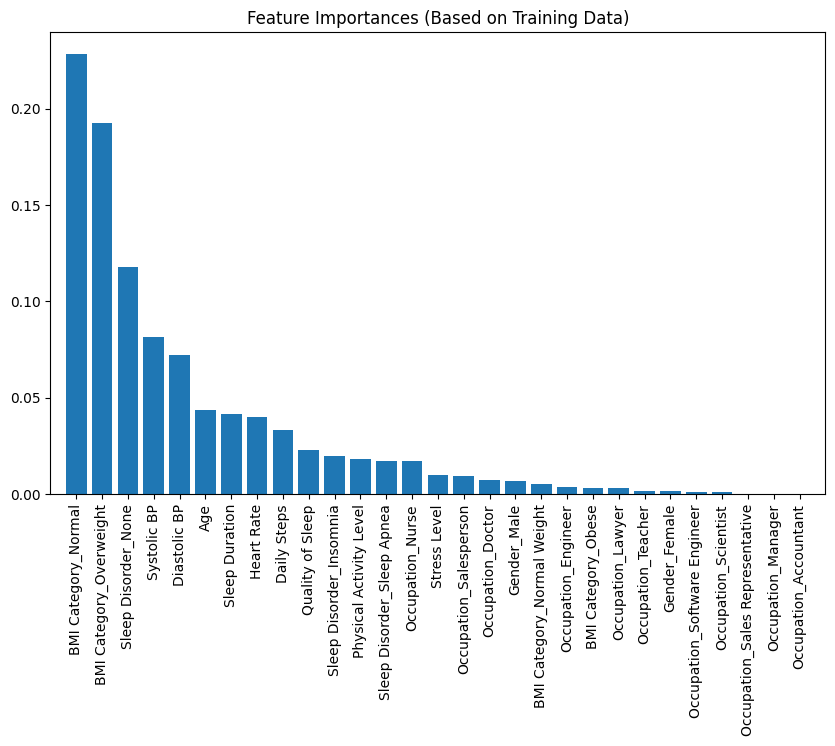

In [5]:
from sklearn.ensemble import RandomForestClassifier

# As X_train and y_train is our preprocessed and split training data

# Fit a Random Forest Classifier on the training data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # Note: Use X_train, not X_train_scaled if scaling was applied

# Get feature importances
importances = rf.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]
sorted_feature_importances = importances[indices]
sorted_feature_names = X_train.columns[indices]  # Ensure this matches with your preprocessed features

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Based on Training Data)")
plt.bar(range(X_train.shape[1]), sorted_feature_importances, align="center")
plt.xticks(range(X_train.shape[1]), sorted_feature_names, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


# Updated Model with only restricted columns -


In [6]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# Calculate class weights for the imbalanced dataset
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Sleep-related features indices from the feature importance graph
sleep_feature_indices = [3, 4, 5, 6, 7, 8, 9]

# Define the model inputs for only sleep-related features
input_layer = Input(shape=(len(sleep_feature_indices),))

# Network for sleep features
sleep_features_dense = Dense(128, activation='relu')(input_layer)

# Output layer
output_layer = Dense(3, activation='softmax')(sleep_features_dense)  # Assuming 3 classes

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with only sleep-related features
history = model.fit(
    X_train_scaled[:, sleep_feature_indices],
    y_train,
    epochs=50,
    validation_split=0.2,
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluate the model on the test set with only sleep-related features
evaluation = model.evaluate(X_test_scaled[:, sleep_feature_indices], y_test)
print(f'Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}')

Epoch 1/50
8/8 [==============================] - 1s 52ms/step - loss: 1.1324 - accuracy: 0.4686 - val_loss: 0.9579 - val_accuracy: 0.5500
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.9608 - accuracy: 0.5565 - val_loss: 0.8719 - val_accuracy: 0.7667
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.8450 - accuracy: 0.7364 - val_loss: 0.7892 - val_accuracy: 0.8000
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.7508 - accuracy: 0.7406 - val_loss: 0.7242 - val_accuracy: 0.8000
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.6793 - accuracy: 0.7364 - val_loss: 0.6646 - val_accuracy: 0.8000
Epoch 6/50
8/8 [==============================] - 0s 9ms/step - loss: 0.6184 - accuracy: 0.7406 - val_loss: 0.6082 - val_accuracy: 0.8167
Epoch 7/50
8/8 [==============================] - 0s 10ms/step - loss: 0.5702 - accuracy: 0.7657 - val_loss: 0.5777 - val_accuracy: 0.8000
Epoch 8/50
8/8 [============

In [8]:
# Ensure to slice `X_test_scaled` to include only the sleep-related features
# Assuming sleep_feature_indices is defined as before
from sklearn.metrics import classification_report, confusion_matrix
# Predict classes on the test set using only sleep-related features
y_pred_probs = model.predict(X_test_scaled[:, sleep_feature_indices])
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=['Fit', 'Non-Fit', 'Highly Non-Fit'])
print(report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

3/3 [==============================] - 0s 5ms/step
                precision    recall  f1-score   support

           Fit       0.98      1.00      0.99        42
       Non-Fit       1.00      0.62      0.77        32
Highly Non-Fit       0.08      1.00      0.15         1

      accuracy                           0.84        75
     macro avg       0.69      0.88      0.64        75
  weighted avg       0.97      0.84      0.88        75

[[42  0  0]
 [ 1 20 11]
 [ 0  0  1]]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')